In [1]:
# Imports 

# Standard
import numpy as np
import pandas as pd
import os
import pickle

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelling
from xgboost import XGBRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Perceptron
from tensorflow.keras import Sequential, layers, optimizers, callbacks, Input
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

# Metrics & evaluation
from sklearn.metrics import r2_score, mean_absolute_error

# Visualisation
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

2024-06-26 11:04:06.860423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paths 

DATA_DIR_PATH = 'data'

<u>Data preparation</u>

In [3]:
# Import DVF data (https://app.dvf.etalab.gouv.fr/) 

csv_file_list = [file.name for file in os.scandir(DATA_DIR_PATH) if file.name.endswith('.csv')]

df = pd.DataFrame()

transac_count = 0

for file in csv_file_list:
    new_file = pd.read_csv(os.path.join(DATA_DIR_PATH, file), sep=';')
    new_file['section']=file[9:11]
    transac_count += len(new_file)
    df = pd.concat([df,new_file], ignore_index=True)

# Check
# transac_count == len(df)

In [4]:
# Set dataset index

df.set_index('id_mutation', inplace=True)

In [5]:
# drop unnecessary data

df = df.copy()
df.drop(columns=['numero_disposition', 'code_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 
                 'ancien_id_parcelle', 'adresse_suffixe','adresse_code_voie', 'lot1_numero', 'lot2_numero', 'lot3_numero', 
                 'lot4_numero', 'lot5_numero', 'lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez', 'section_prefixe',
                 'lot4_surface_carrez', 'lot5_surface_carrez', 'nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 
                 'code_type_local', 'nature_culture', 'code_nature_culture', 'code_nature_culture_speciale', 
                 'nature_culture_speciale', 'section_prefixe', 'adresse_numero', 'adresse_nom_voie', 'code_postal', 'nombre_lots']
        , inplace=True)

In [6]:
# Convert dates

df.date_mutation = pd.to_datetime(df.date_mutation)

In [7]:
# Identify missing values

missing_values_df = df.isnull().sum()
total_data_points = df.shape[0]
missing_percentage_df = round((missing_values_df / total_data_points) * 100,0)
missing_data_summary = pd.concat([missing_values_df, missing_percentage_df], axis=1)
missing_data_summary.columns = ['Missing Values', 'Percentage']

print(f'Check - missing values in df (out of {total_data_points} total values):')
print(missing_data_summary)

Check - missing values in df (out of 17781 total values):
                           Missing Values  Percentage
date_mutation                           0         0.0
nature_mutation                         0         0.0
valeur_fonciere                        29         0.0
type_local                           6392        36.0
surface_reelle_bati                 11166        63.0
nombre_pieces_principales            6400        36.0
surface_terrain                     12118        68.0
longitude                             597         3.0
latitude                              597         3.0
section                                 0         0.0


In [8]:
# Replace missing values

df[['surface_terrain']] = df[['surface_terrain']].fillna(0)
df[['nombre_pieces_principales']] = df[['nombre_pieces_principales']].fillna(0)

In [9]:
# Drop missing values

df = df.dropna(subset=['valeur_fonciere','surface_reelle_bati','type_local','longitude', 'latitude'])

In [10]:
# Add inondation risk information (info from https://georisques.gouv.fr/)

quartier_risque_df = pd.read_csv('section-inondable.csv', sep=';')
df = pd.merge(df, quartier_risque_df, how='left', left_on='section',right_on='section_prefixe')

In [11]:
# Add price per sqm

df['prix_m2'] = df['valeur_fonciere']/df['surface_reelle_bati']

In [12]:
# Filter according to transaction type, date, and reshuffle

df = df[(df.nature_mutation.isin(['Vente', "Vente en l'état futur d'achèvement"])) &
        (df.type_local.isin(['Maison', 'Appartement'])) &
        (df.date_mutation > '2022-01-01')] # Roughly stable prices since 2024

In [13]:
# Encode "maison ou appartement"

df['maison'] = (df['type_local'] == "Maison").astype(int)
df.drop(columns=['type_local'], inplace=True)

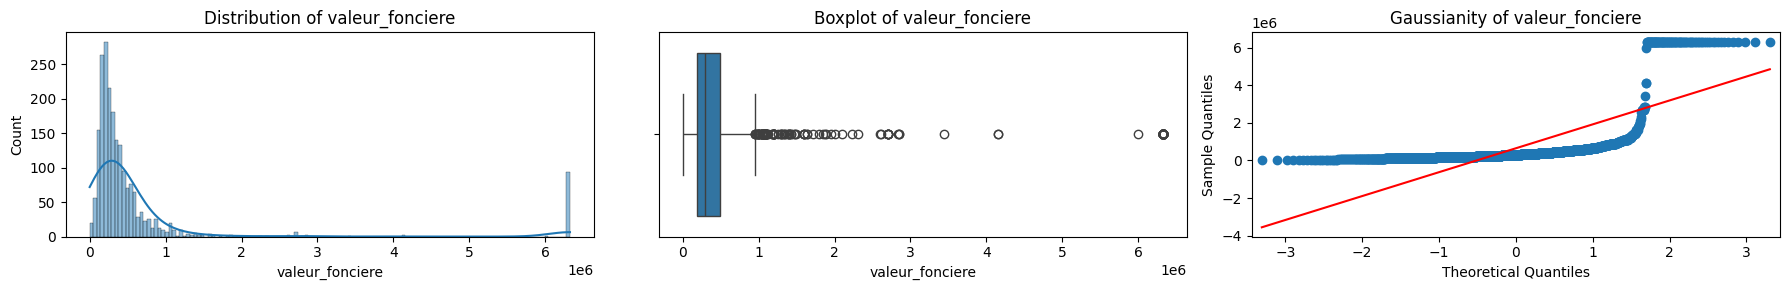

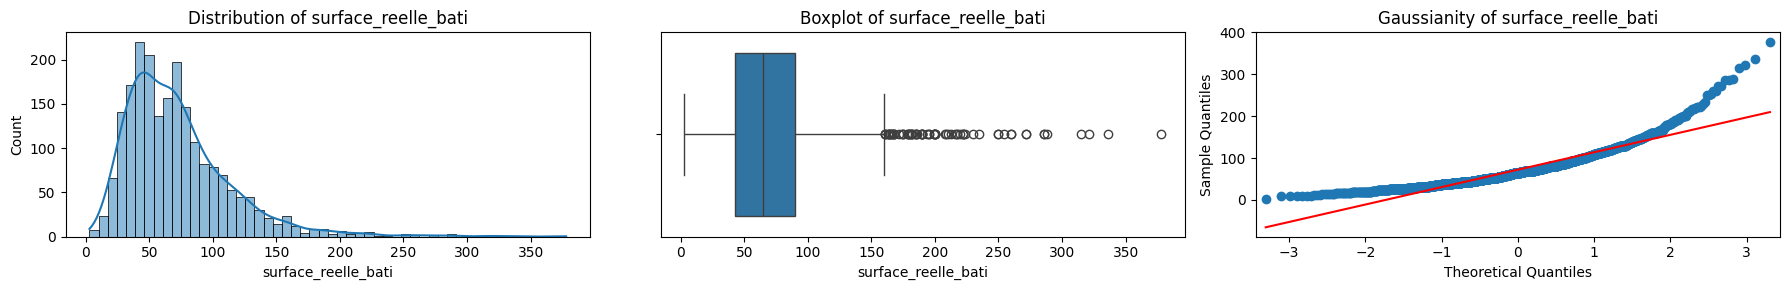

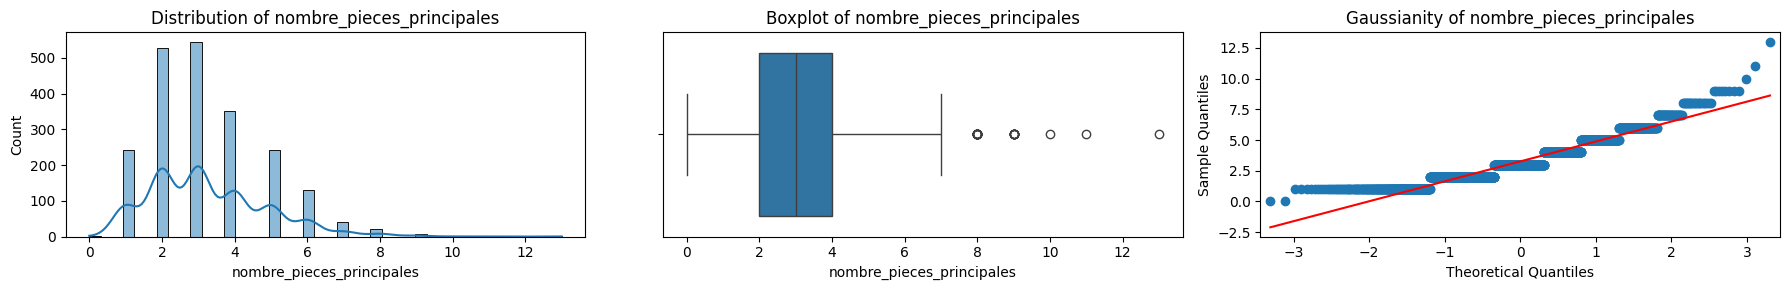

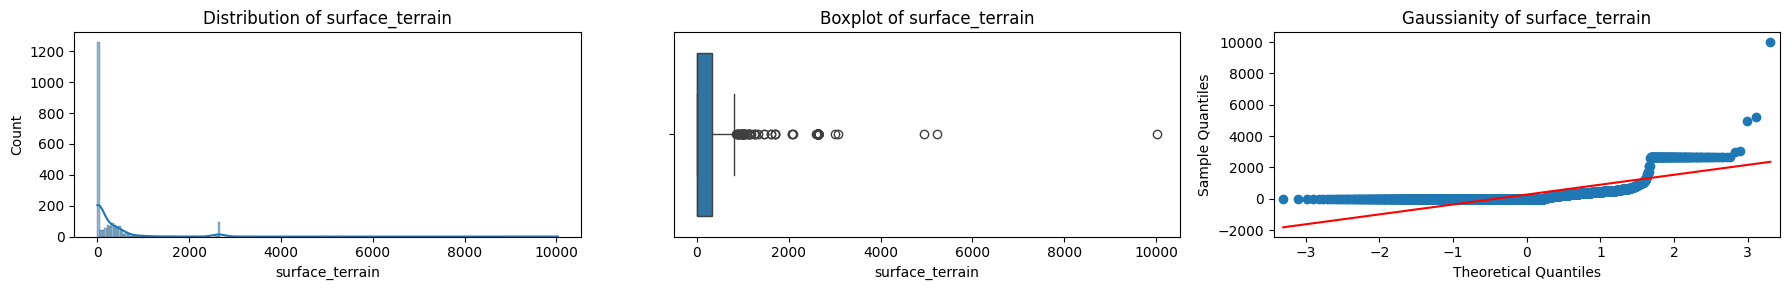

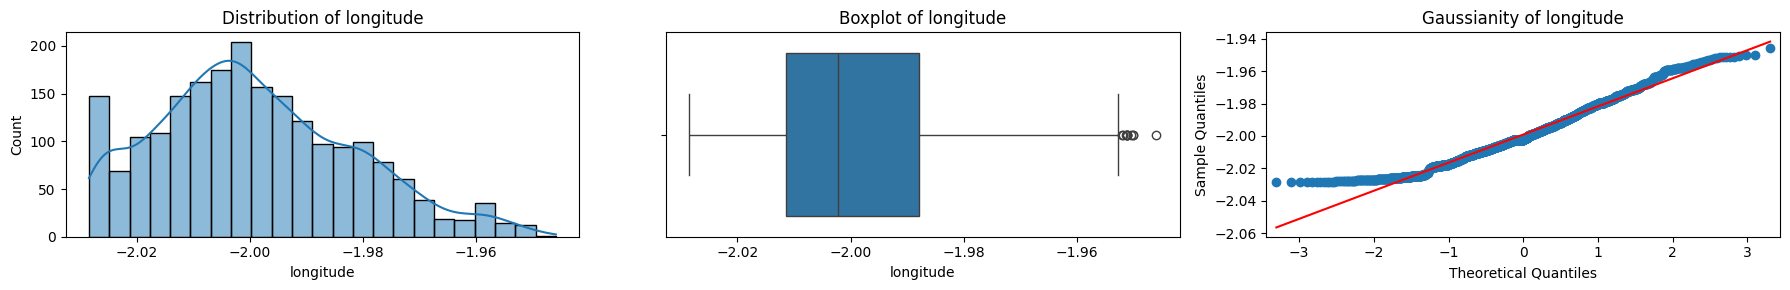

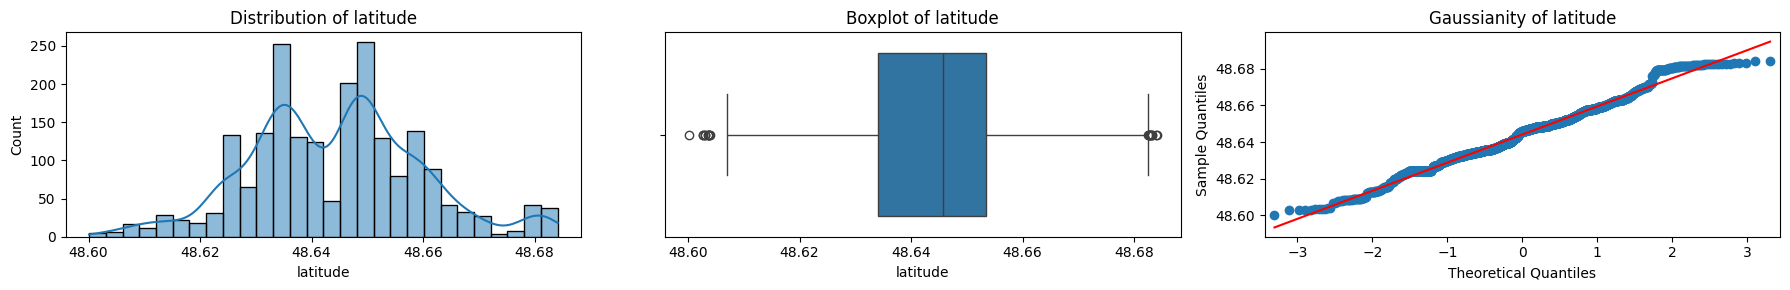

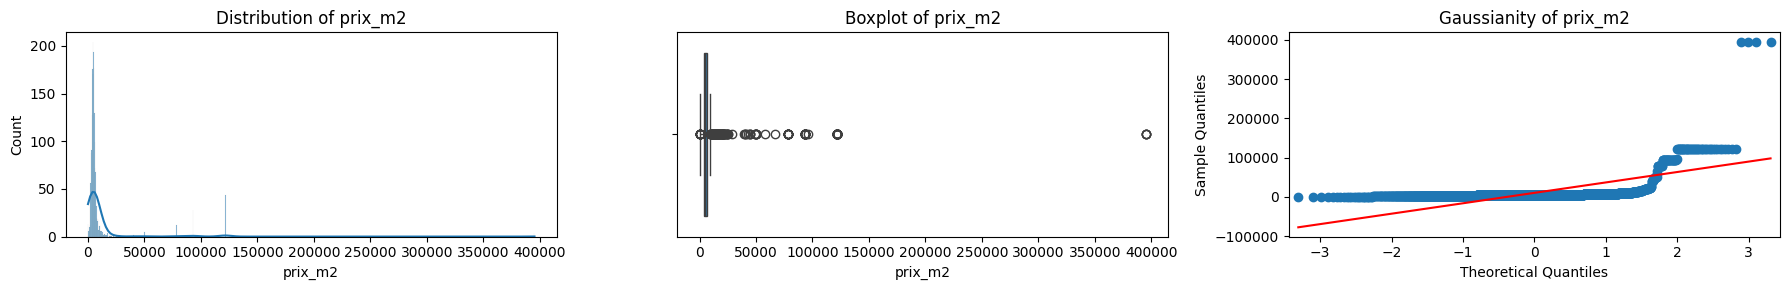

In [14]:
# Plot distribution, boxplot and QQ plots (full dataset)

features = ['valeur_fonciere', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude', 'prix_m2']

for feature in features:
    fig, ax = plt.subplots(1, 3, figsize=(18, 3))
    
    # Distribution plot
    ax[0].set_title(f"Distribution of {feature}")
    sns.histplot(data=df, x=feature, kde=True, ax=ax[0])
    
    # Boxplot
    ax[1].set_title(f"Boxplot of {feature}")
    sns.boxplot(data=df, x=feature, ax=ax[1])
    
    # Q-Q plot for Gaussianity
    ax[2].set_title(f"Gaussianity of {feature}")
    qqplot(df[feature], line='s', ax=ax[2])
    
    plt.tight_layout()
    plt.show()

In [15]:
# Plot price per sqm

#max_axe = 20000
#plt.figure(figsize=(10, 6))
#plt.hist(df['prix_m2'], bins=50, range=(0, max_axe), edgecolor='black', color='skyblue')
#plt.title('Price per sqm (before data selection)')
#plt.xlabel('Price per sqm')
#plt.ylabel('Frequency')
#plt.xlim(0, max_axe)

In [16]:
# overview of prix_m2

#bins = pd.cut(df['prix_m2'][df['prix_m2']<10000], bins=10)
#bin_counts = bins.value_counts().sort_index()
#bin_counts_df = pd.DataFrame(bin_counts).reset_index()
#bin_counts_df.columns = ['Bin', 'Count']
#bin_counts_df

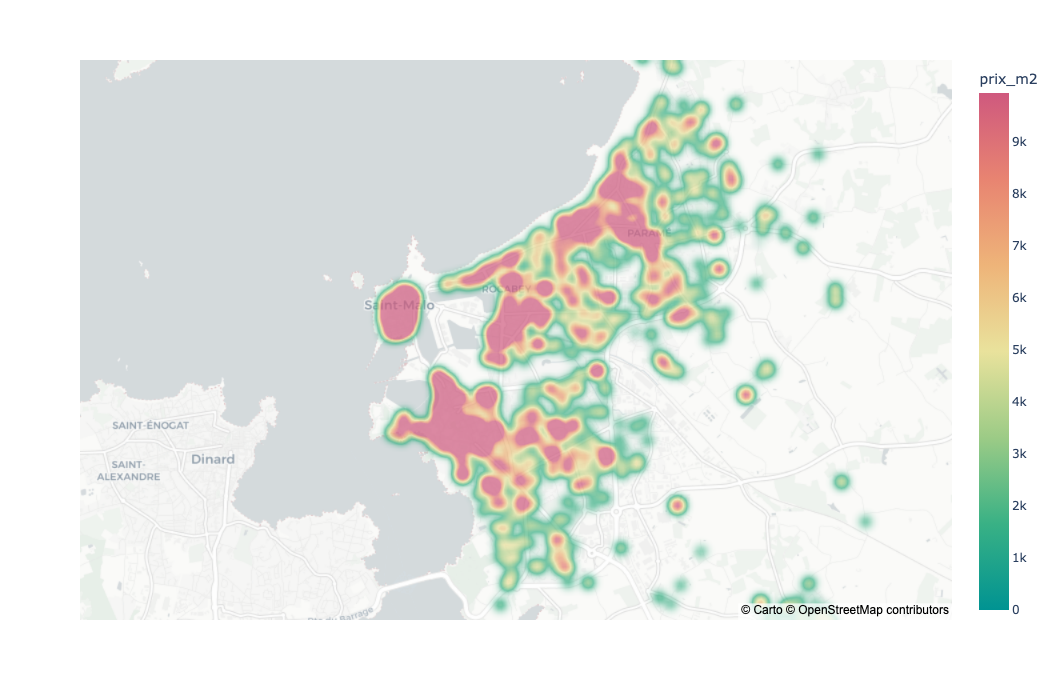

In [17]:
# Plot a map of St Malo

prix_max = 10000
df_prix_max = df[df['prix_m2']<prix_max]

fig = px.density_mapbox(df_prix_max, lat = df_prix_max['latitude'], lon = df_prix_max['longitude'], z = df_prix_max['prix_m2'],
                        radius = 15,
                        center = dict(lat = 48.645508618488854, lon = -2.005960078289662),
                        zoom = 12,
                        mapbox_style = 'carto-positron',
                        opacity=0.7,
                       color_continuous_scale=px.colors.diverging.Temps)
fig.update_layout(
    width=1000,
    height=700 
)
fig.show()

In [18]:
# Get whiskers

def compute_whiskers(df_column):
    Q1 = np.percentile(df_column, 25)
    Q3 = np.percentile(df_column, 75)
    IQR = Q3 - Q1
    
    lower_whisker = np.max([np.min(df_column), Q1 - 1.5 * IQR])
    upper_whisker = np.min([np.max(df_column), Q3 + 1.5 * IQR])
    
    return lower_whisker.round(1), upper_whisker.round(1)

for column in features : 
    print(f'whiskers {column}: {compute_whiskers(df[column])}')

whiskers valeur_fonciere: (1.0, 953125.0)
whiskers surface_reelle_bati: (3.0, 160.5)
whiskers nombre_pieces_principales: (0.0, 7.0)
whiskers surface_terrain: (0.0, 811.2)
whiskers longitude: (-2.0, -2.0)
whiskers latitude: (48.6, 48.7)
whiskers prix_m2: (292.2, 9654.2)


In [19]:
# Drop outliers or unrelevant data

df_filtered = df[df['surface_terrain'] < 800]

df_filtered = df_filtered[df_filtered['surface_reelle_bati'] > 9]
df_filtered = df_filtered[df_filtered['surface_reelle_bati'] < 160]

df_filtered = df_filtered[df_filtered['valeur_fonciere'] < 1000000]

df_filtered = df_filtered[df_filtered['prix_m2'] < 10000]
df_filtered = df_filtered[df_filtered['prix_m2'] > 1000]

df_filtered = df_filtered[df_filtered['latitude'] > 48.62555]
df_filtered = df_filtered[abs(df_filtered['longitude']) > 1.96098]

#df_filtered = df_filtered.sample(frac=1, random_state=42).reset_index(False)

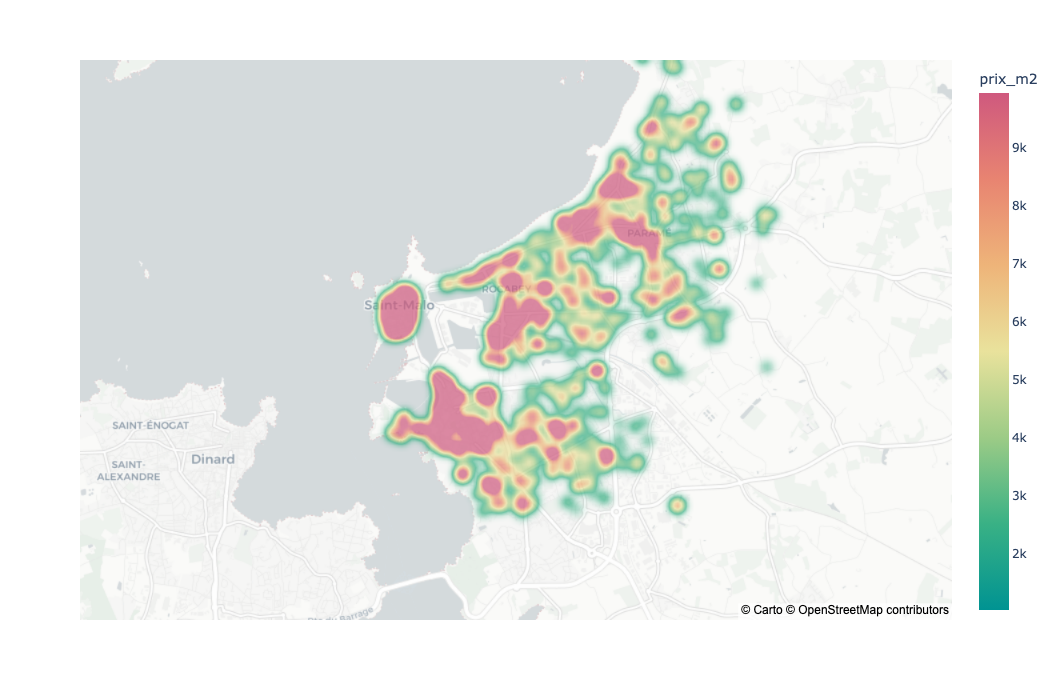

In [20]:
# Plot a map of St Malo (after dropping of outliers)

fig = px.density_mapbox(df_filtered, lat = df_filtered['latitude'], lon = df_filtered['longitude'], z = df_filtered['prix_m2'],
                        radius = 15,
                        center = dict(lat = 48.645508618488854, lon = -2.005960078289662),
                        zoom = 12,
                        mapbox_style = 'carto-positron',
                        opacity=0.7,
                       color_continuous_scale=px.colors.diverging.Temps)
fig.update_layout(
    width=1000,
    height=700 
)
fig.show()

In [21]:
# Create X and y

X = df_filtered[['surface_reelle_bati','nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude','maison']]
y = df_filtered['valeur_fonciere']/1000

In [22]:
# Create train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<u>0. Scaling </u>

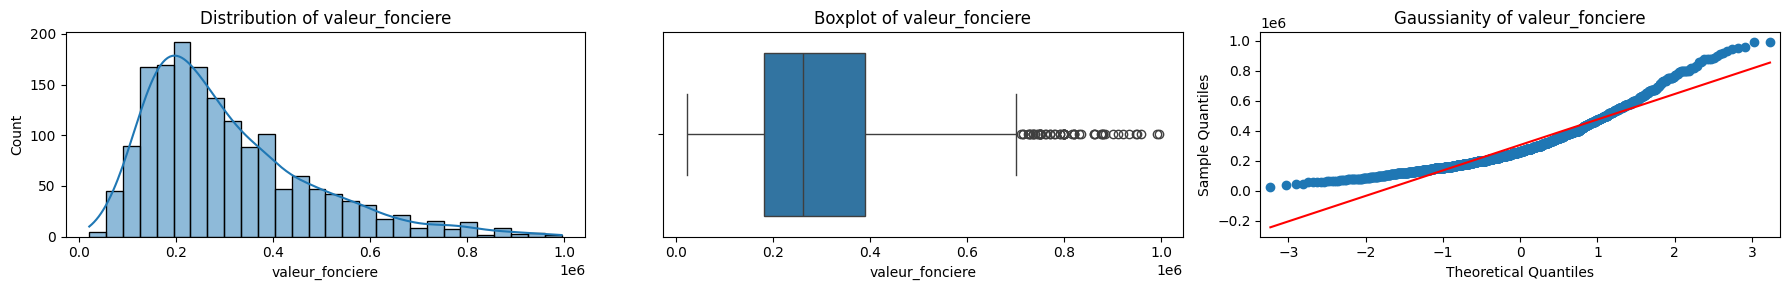

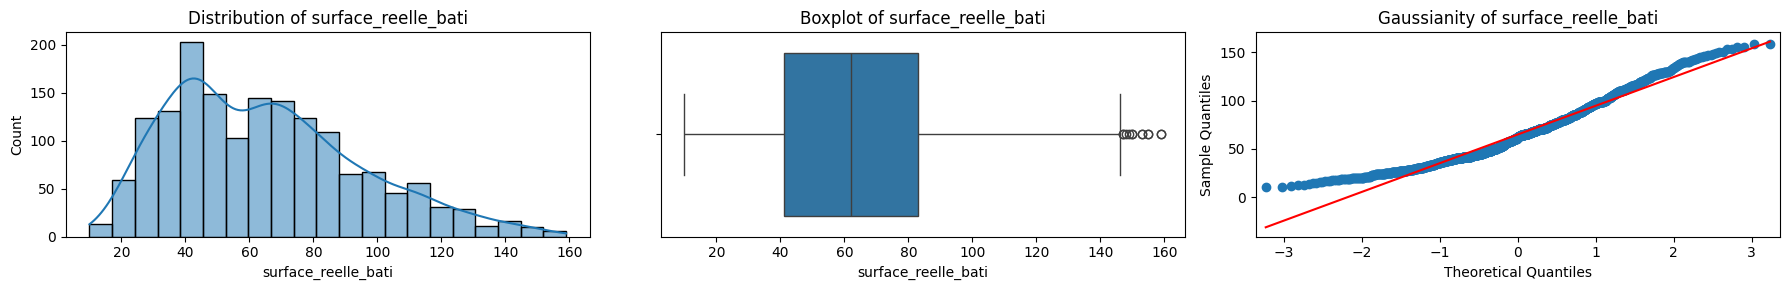

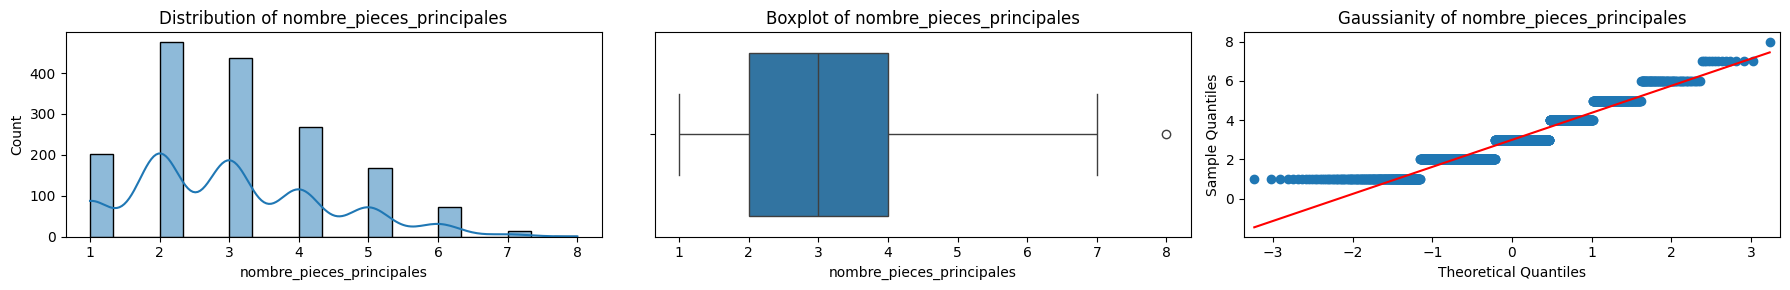

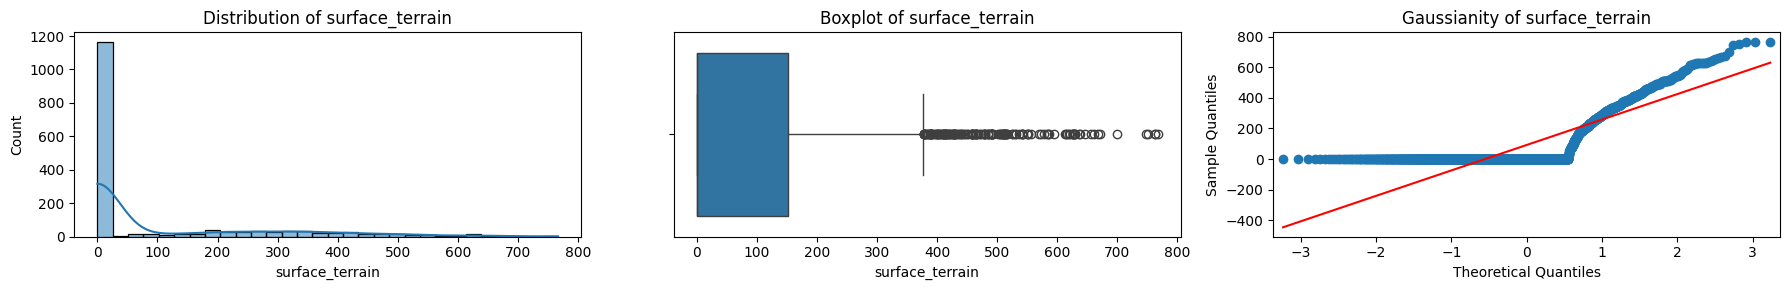

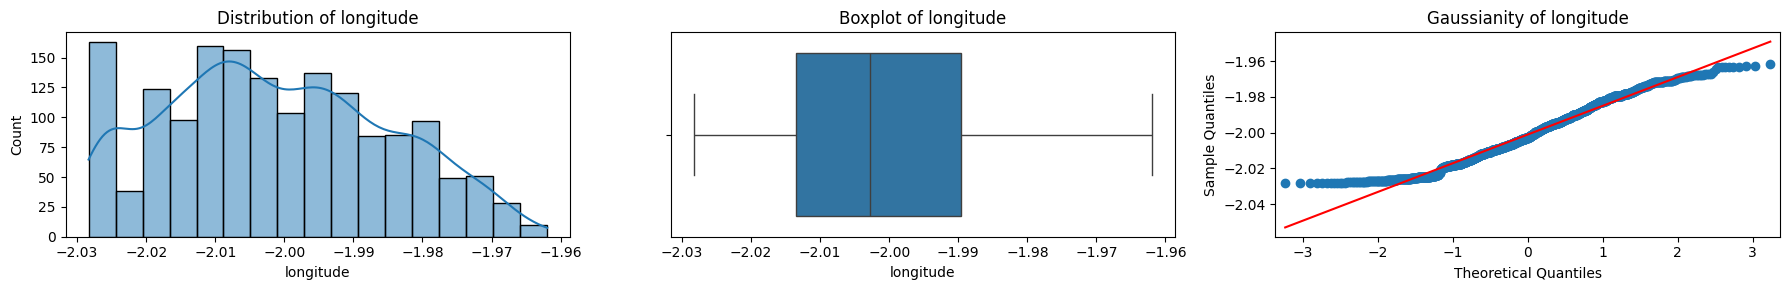

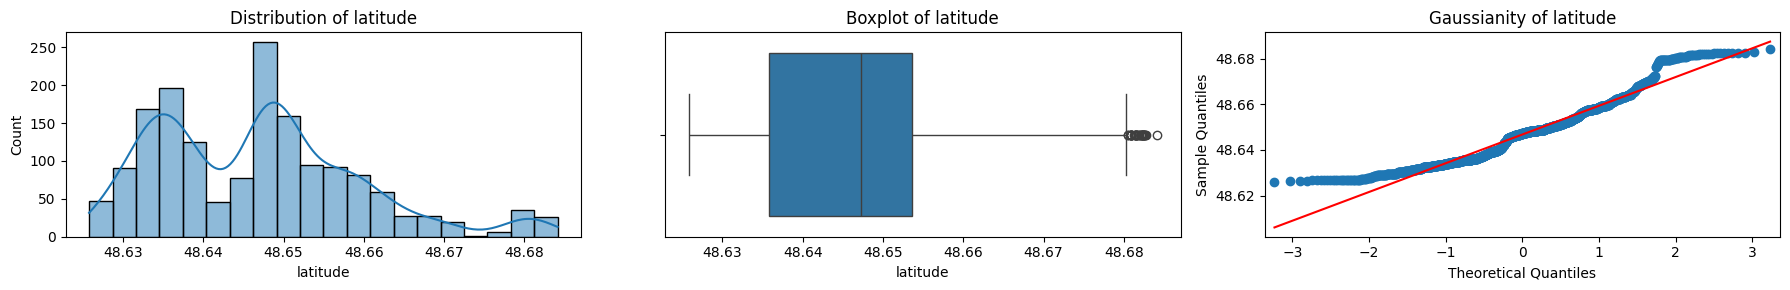

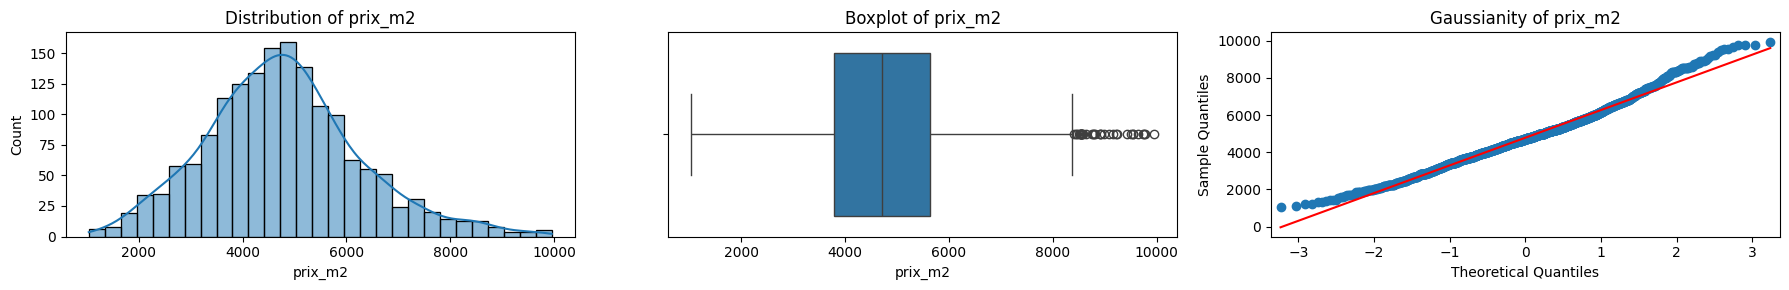

In [23]:
# Plot distribution, boxplot and QQ plots (after droping of outliers)

features = ['valeur_fonciere', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude', 'prix_m2']

for feature in features:
    fig, ax = plt.subplots(1, 3, figsize=(18, 3))
    
    # Distribution plot
    ax[0].set_title(f"Distribution of {feature}")
    sns.histplot(data=df_filtered, x=feature, kde=True, ax=ax[0])
    
    # Boxplot
    ax[1].set_title(f"Boxplot of {feature}")
    sns.boxplot(data=df_filtered, x=feature, ax=ax[1])
    
    # QQ plot for Gaussianity
    ax[2].set_title(f"Gaussianity of {feature}")
    qqplot(df_filtered[feature], line='s', ax=ax[2])
    
    plt.tight_layout()
    plt.show()

In [24]:
# Scaling X (linear regression, neural network)

preprocessor = ColumnTransformer(transformers=[
                                    ('std', StandardScaler(), ['surface_reelle_bati', 'nombre_pieces_principales']),
                                    ('minmax', MinMaxScaler(), ['surface_terrain', 'longitude', 'latitude'])
], remainder='passthrough')

In [25]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [26]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'longitude', 'latitude','maison'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'longitude', 'latitude','maison'])

In [27]:
# Scaling y (neural network)

std = StandardScaler()
y_train_scaled = std.fit_transform(pd.DataFrame(y_train))
y_test_scaled = std.transform(pd.DataFrame(y_test))

In [28]:
# Store future scores

test_set_score = {}
test_set_mae = {}
test_set_mae_sqm = {}
predicted_price = {} # compare prediction for a new, unseen flat

<u>2. Baseline</u>

In [29]:
# Average price per sqm (full dataset) 

mean_price_sqm = y_train.sum() / X_train.surface_reelle_bati.sum()

print(f'Average price in St Malo (selected dataset): {mean_price_sqm.round(2)} kEUR/sqm')

Average price in St Malo (selected dataset): 4.71 kEUR/sqm


In [30]:
# Cross validate

kf = KFold(n_splits=5)
cv_scores_baseline = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_pred_baseline_fold = X_test_fold['surface_reelle_bati'] * mean_price_sqm
    baseline_fold_r2 = r2_score(y_test_fold, y_pred_baseline_fold)
    cv_scores_baseline.append(baseline_fold_r2)

print(f'Average score on X_train folds: {np.mean(cv_scores_baseline).round(2)}')
print(f'Standard deviation of score on X_train folds: {np.std(cv_scores_baseline).round(2)}')

Average score on X_train folds: 0.6
Standard deviation of score on X_train folds: 0.03


In [31]:
# Predict y_test and scoring

y_pred_baseline = X_test['surface_reelle_bati'] * mean_price_sqm
test_set_score_baseline = round(r2_score(y_test,y_pred_baseline),2)

print(f'Score test set: {test_set_score_baseline}')

Score test set: 0.61


In [32]:
# Compute the mean absolute error

mae_baseline = mean_absolute_error(y_pred_baseline, y_test).round(0)
mae_sqm_baseline = np.mean(abs(y_pred_baseline - y_test) / X_test.surface_reelle_bati).round(1)

print(f'Mean absolute error on test set: {mae_baseline} kEUR')
print(f'Mean absolute error per sqm on test set: {mae_sqm_baseline} kEUR/sqm')

Mean absolute error on test set: 74.0 kEUR
Mean absolute error per sqm on test set: 1.2 kEUR/sqm


In [33]:
# Predict new y

X_new_value = {'surface_reelle_bati':66,'nombre_pieces_principales':1,'surface_terrain':5, 'longitude':-2.0137840051905065, 'latitude':48.63496722646819, 'maison':0}
X_new_value = pd.DataFrame([X_new_value])

In [34]:
y_new_value_baseline = round(mean_price_sqm * X_new_value.surface_reelle_bati[0],0)
print(f'Predicted price: {y_new_value_baseline} kEUR')

Predicted price: 311.0 kEUR


In [35]:
# Store scores

test_set_score['baseline'] = test_set_score_baseline
test_set_mae['baseline'] = mae_baseline
test_set_mae_sqm['baseline'] = mae_sqm_baseline
predicted_price['baseline'] = y_new_value_baseline

<u>3. Linear regression</u>

In [36]:
# cv scores on X_train

linear_model = LinearRegression()
cv_scores_linear = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f'Average score on X_train folds: {np.mean(cv_scores_linear).round(2)}')
print(f'Standard deviation of score on X_train folds: {np.std(cv_scores_linear).round(2)}')

Average score on X_train folds: 0.67
Standard deviation of score on X_train folds: 0.02


In [37]:
# Predict y_pred and score

linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
test_set_score_linear = round(linear_model.score(X_test_scaled, y_test),2)

print(f'Score test set: {test_set_score_linear}')

Score test set: 0.69


In [38]:
# Compute the mean absolute error

mae_linear = mean_absolute_error(y_pred_linear, y_test).round(0)
mae_sqm_linear = np.mean(abs(y_pred_linear - y_test) / X_test.surface_reelle_bati).round(1)

print(f'Mean absolute error on test set: {mae_linear} kEUR')
print(f'Mean absolute error per sqm on test set: {mae_sqm_linear} kEUR/sqm')

Mean absolute error on test set: 68.0 kEUR
Mean absolute error per sqm on test set: 1.1 kEUR/sqm


In [39]:
# Predict new y

X_new_value_scaled = preprocessor.transform(X_new_value)
X_new_value_scaled = pd.DataFrame(X_new_value_scaled, columns = ['surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'longitude', 'latitude','maison'])

y_new_value_linear = round(linear_model.predict(X_new_value_scaled)[0],0)
print(f'Predicted price: {y_new_value_linear} kEUR')

Predicted price: 292.0 kEUR


In [40]:
# Store scores

test_set_score['linear-reg'] = test_set_score_linear
test_set_mae['linear-reg'] = mae_linear
test_set_mae_sqm['linear-reg'] = mae_sqm_linear
predicted_price['linear-reg'] = y_new_value_linear

<u>3. XGBoostRegressor</u>

In [41]:
xgb_regressor_baseline = XGBRegressor()
cv_score_xgb_baseline = cross_val_score(xgb_regressor_baseline, X_train, y_train, cv=5, scoring='r2')

print(f'Average score on X_train for baseline XGB Regressor: {cv_score_xgb_baseline.mean().round(2)}')

Average score on X_train for baseline XGB Regressor: 0.64


In [42]:
# Search for the best params (commented after search)

#xgb_params = {
#            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 40, num = 10)],
#            'max_depth' : [None, 1, 2, 4, 5, 6, 7],
#            'min_child_weight': [None, 1, 5],
#            'gamma': [0.5, 1, 1.5, 2, 5]
#        }

#xgb_search = GridSearchCV(estimator = xgb_regressor_baseline,
#                                   param_grid = xgb_params,
#                                   scoring='neg_mean_absolute_error',
#                                   cv = 5,
#                                   verbose=1,
#                                   n_jobs = -1)

#xgb_search.fit(X_train, y_train)

In [43]:
#xgb_best = xgb_search.best_estimator_
#xgb_best.get_params()

xgb_best = XGBRegressor(max_depth = 4, n_estimators = 16, gamma = 0.5)
cv_scores_best_xgb = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='r2')

print(f'Average score on X_train folds: {cv_scores_best_xgb.mean().round(2)}')
print(f'Standard deviation of score on X_train folds: {np.std(cv_scores_best_xgb).round(2)}')

Average score on X_train folds: 0.68
Standard deviation of score on X_train folds: 0.02


In [44]:
# Predict y_pred and score

xgb_best.fit(X_train,y_train)
y_pred_xgb = xgb_best.predict(X_test)
test_set_score_xgb = round(xgb_best.score(X_test,y_test),2)

print(f'Score test set: {test_set_score_xgb}')

Score test set: 0.75


In [45]:
# Visualize & save tree structure 

plt.figure(figsize=(12, 12))
#plot_tree(xgb_best,fontsize=20)
plt.savefig('XGB_tree_ploted', dpi=400)

<Figure size 1200x1200 with 0 Axes>

In [46]:
# Compute the mean absolute error

mae_xgb = mean_absolute_error(y_pred_xgb, y_test).round(0)
mae_sqm_xgb = np.mean(abs(y_pred_xgb - y_test) / X_test.surface_reelle_bati).round(1)

print(f'Mean absolute error on test set: {mae_xgb} kEUR')
print(f'Mean absolute error per sqm on test set: {mae_sqm_xgb} kEUR/sqm')

Mean absolute error on test set: 58.0 kEUR
Mean absolute error per sqm on test set: 0.9 kEUR/sqm


In [47]:
# Predict new y

y_new_value_xgb = round(xgb_best.predict(X_new_value)[0],0)
print(f'Predicted price: {y_new_value_xgb} kEUR')

Predicted price: 250.0 kEUR


In [48]:
test_set_score['xgboost'] = test_set_score_xgb
test_set_mae['xgboost'] = mae_xgb
test_set_mae_sqm['xgboost'] = mae_sqm_xgb
predicted_price['xgboost'] = y_new_value_xgb

<u>4. Simple neural network</u>

In [49]:
# Decay functions for learning rate evolution

initial_learning_rate = 0.01

#lr_schedule_step = optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=10000,
#    decay_rate=0.96,
#    staircase=True)

#lr_schedule_expo = optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=1000,
#    decay_rate=0.96,
#    staircase=False)

#lr_schedule_poly = optimizers.schedules.PolynomialDecay(
#    initial_learning_rate,
#    decay_steps=10000,
#    end_learning_rate=0.0001,
#    power=2.0)

lr_schedule_cosine = optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=10000)

# optimizer
optimizer = optimizers.Adam(learning_rate=lr_schedule_cosine)

In [50]:
# Simple neural network model architecture
nn_model = Sequential()
nn_model.add(layers.Input(shape=(X_train_scaled.shape[-1],)))
nn_model.add(layers.Dense(20, activation='relu'))
nn_model.add(layers.Dense(15, activation='relu'))
nn_model.add(layers.Dense(15, activation='relu'))
nn_model.add(layers.Dense(20, activation='relu'))
nn_model.add(layers.Dense(1, activation='linear'))

# Compiler
nn_model.compile(optimizer=optimizer,loss='mae',metrics=['mae']) # msle loss to penalize large difference

# Fit
history = nn_model.fit(X_train_scaled, y_train, batch_size=32, epochs=20)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 286.4474 - mae: 286.4474
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91.2667 - mae: 91.2667
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73.4543 - mae: 73.4543
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.2622 - mae: 72.2622
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.7143 - mae: 72.7143
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68.3471 - mae: 68.3471
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.8167 - mae: 67.8167
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.6777 - mae: 70.6777
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72.2934 - mae: 72.2934
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.2978 - mae: 71.2978
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.0291 - mae: 70.0291
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.6440 - mae: 68.6440
Epoch 13/20
41/41 ━━━━━

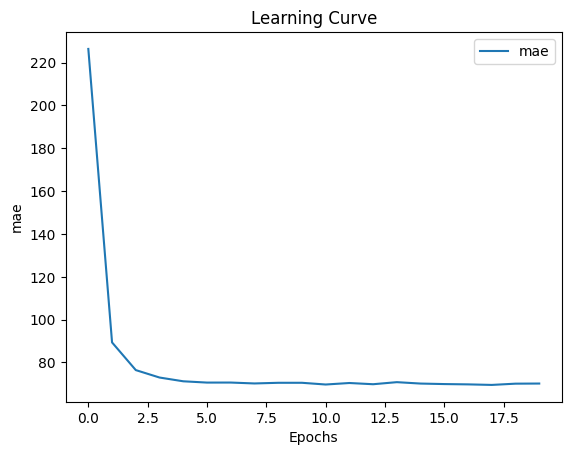

In [51]:
plt.plot(history.history['mae'], label='mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [52]:
y_pred_nn = nn_model.predict(X_test_scaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [53]:
test_set_score_nn = round(r2_score(y_test, y_pred_nn),2)
print(f'Score test set: {test_set_score_nn}')

Score test set: 0.67


In [54]:
# Compute the mean absolute error

mae_nn = mean_absolute_error(y_pred_nn.flatten(), y_test).round(0)
mae_sqm_nn = np.mean(abs(y_pred_nn.flatten() - y_test) / X_test.surface_reelle_bati).round(1)

print(f'Mean absolute error on test set: {mae_nn} kEUR')
print(f'Mean absolute error per sqm on test set: {mae_sqm_nn} kEUR/sqm')

Mean absolute error on test set: 67.0 kEUR
Mean absolute error per sqm on test set: 1.1 kEUR/sqm


In [55]:
y_new_value_nn = round(nn_model.predict(X_new_value_scaled)[0][0],0)
print(f'Predicted price: {y_new_value_nn} kEUR')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted price: 254.0 kEUR


In [56]:
test_set_score['simple-nn'] = test_set_score_nn
test_set_mae['simple-nn'] = mae_nn
test_set_mae_sqm['simple-nn'] = mae_sqm_nn
predicted_price['simple-nn'] = y_new_value_nn

<u>5. Model comparison</u>

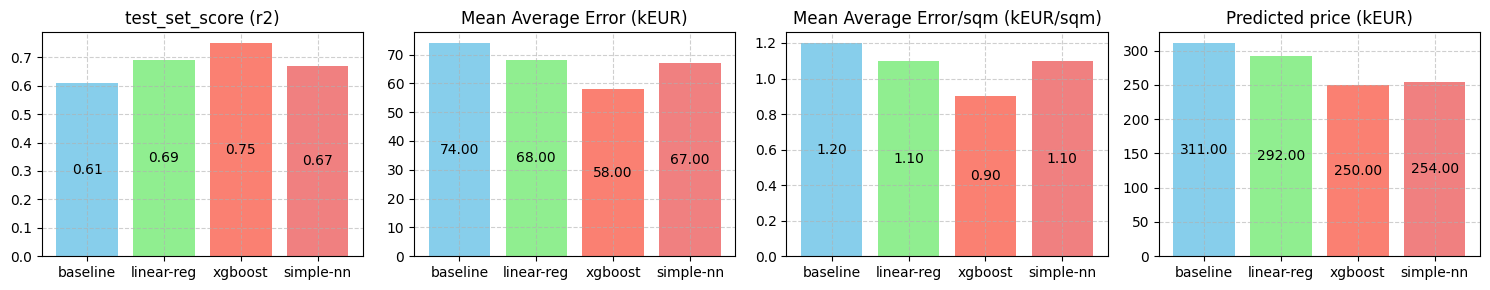

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
scores = [test_set_score, test_set_mae, test_set_mae_sqm, predicted_price]
titles = ['test_set_score (r2)', 'Mean Average Error (kEUR)', 'Mean Average Error/sqm (kEUR/sqm)', 'Predicted price (kEUR)']

for ax, score, title in zip(axes.flatten(), scores, titles):
    names = list(score.keys())
    values = list(score.values())
    bars = ax.bar(names, values, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.6)
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{value:.2f}", ha='center', va='center')
        
plt.tight_layout()
plt.show()

In [58]:
pickle.dump(xgb_best, open('xgboost-immo.pkl', 'wb'))